In [31]:
%%shell
pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 7.9 MB/s eta 0:00:00


In [160]:
import re
import nltk
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from unidecode import unidecode
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from collections import Counter
from functools import reduce
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
nltk.download("popular")

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

True

# Bag-of-Words (BoW)

In [3]:
text = (
    "este es un texto de ejemplo, en el que abordamos temas sobre representacion"
    " y codificacion de palabras en vectores numericos"
)

In [4]:
print(text)

este es un texto de ejemplo, en el que abordamos temas sobre representacion y codificacion de palabras en vectores numericos


In [7]:
tokens = word_tokenize(text)

In [8]:
tokens

['este',
 'es',
 'un',
 'texto',
 'de',
 'ejemplo',
 ',',
 'en',
 'el',
 'que',
 'abordamos',
 'temas',
 'sobre',
 'representacion',
 'y',
 'codificacion',
 'de',
 'palabras',
 'en',
 'vectores',
 'numericos']

# manual

In [10]:
counts = {}
for token in tokens:
    if not token in counts:
        counts[token] = 1
    else:
        counts[token] += 1

In [11]:
counts

{'este': 1,
 'es': 1,
 'un': 1,
 'texto': 1,
 'de': 2,
 'ejemplo': 1,
 ',': 1,
 'en': 2,
 'el': 1,
 'que': 1,
 'abordamos': 1,
 'temas': 1,
 'sobre': 1,
 'representacion': 1,
 'y': 1,
 'codificacion': 1,
 'palabras': 1,
 'vectores': 1,
 'numericos': 1}

nativo

In [13]:
counts = Counter(tokens)
counts

Counter({'este': 1,
         'es': 1,
         'un': 1,
         'texto': 1,
         'de': 2,
         'ejemplo': 1,
         ',': 1,
         'en': 2,
         'el': 1,
         'que': 1,
         'abordamos': 1,
         'temas': 1,
         'sobre': 1,
         'representacion': 1,
         'y': 1,
         'codificacion': 1,
         'palabras': 1,
         'vectores': 1,
         'numericos': 1})

numpy

In [16]:
tokens_np = np.array(tokens)
words, counts = np.unique(tokens_np, return_counts=True)
counts = dict(zip(words, counts))
counts

{',': 1,
 'abordamos': 1,
 'codificacion': 1,
 'de': 2,
 'ejemplo': 1,
 'el': 1,
 'en': 2,
 'es': 1,
 'este': 1,
 'numericos': 1,
 'palabras': 1,
 'que': 1,
 'representacion': 1,
 'sobre': 1,
 'temas': 1,
 'texto': 1,
 'un': 1,
 'vectores': 1,
 'y': 1}

pandas

In [20]:
ser = (
    pd.Series(data=tokens)
    .value_counts()
    .to_dict()
)
ser

{'de': 2,
 'en': 2,
 'este': 1,
 'temas': 1,
 'vectores': 1,
 'palabras': 1,
 'codificacion': 1,
 'y': 1,
 'representacion': 1,
 'sobre': 1,
 'que': 1,
 'abordamos': 1,
 'es': 1,
 'el': 1,
 ',': 1,
 'ejemplo': 1,
 'texto': 1,
 'un': 1,
 'numericos': 1}

1. Calcular un vocabulario.
2. Crear tabla de conversion `word → int`
2. Calcular conteos por cada documento.
3. Obtener matriz a partir de los conteos y la tabla de conversion.

In [27]:
raw_text = """Alan Mathison Turing (Paddington, Londres; 23 de junio de 1912-Wilmslow, Cheshire; 7 de junio de 1954) fue un matemático, lógico, informático teórico, criptógrafo, filósofo y biólogo teórico británico.1​2​3​4​5​

Es considerado como uno de los padres de la ciencia de la computación y precursor de la informática moderna. Proporcionó una formalización influyente de los conceptos de algoritmo y computación: la máquina de Turing. Formuló su propia versión que hoy es ampliamente aceptada como la tesis de Church-Turing (1936).

Durante la segunda guerra mundial, trabajó en descifrar los códigos nazis, particularmente los de la máquina Enigma, y durante un tiempo fue el director de la sección Naval Enigma de Bletchley Park. Se ha estimado que su trabajo acortó la duración de esa guerra entre dos y cuatro años.6​ Tras la guerra, diseñó uno de los primeros computadores electrónicos programables digitales en el Laboratorio Nacional de Física del Reino Unido y poco tiempo después construyó otra de las primeras máquinas en la Universidad de Mánchester.

En el campo de la inteligencia artificial, es conocido sobre todo por la concepción de la prueba de Turing (1950), un criterio según el cual puede juzgarse la inteligencia de una máquina si sus respuestas en la prueba son indistinguibles de las de un ser humano.

La carrera de Turing terminó súbitamente tras ser procesado por homosexualidad en 1952. Dos años después de su condena, murió —según la versión oficial por suicidio; sin embargo, su muerte ha dado lugar a otras hipótesis, incluida la del envenenamiento accidental —. Después de una campaña pública en 2009, el primer ministro británico, Gordon Brown, se disculpó públicamente en nombre del gobierno británico por «la forma espantosa en la que Turing había sido tratado». La reina Isabel II le otorgó un indulto póstumo en 2013. El término «ley Alan Turing» ahora se usa de manera informal para referirse a una ley de 2017 en el Reino Unido que perdona retroactivamente a hombres amonestados o condenados en virtud de la legislación que prohibía los actos homosexuales.7​

Turing tiene un extenso legado con estatuas y muchas cosas que llevan su nombre, incluido un premio anual por innovación en informática. Aparece en el billete actual de 50 libras del Banco de Inglaterra,8​ que se lanzó el 23 de junio de 2021, coincidiendo con su cumpleaños. Un programa de la BBC de 2019, votado por la audiencia, lo nombró la persona más grande del siglo XX.9​"""

In [28]:
corpus = sent_tokenize(raw_text, language="spanish")

In [29]:
len(corpus)

13

In [30]:
print(corpus[0])

Alan Mathison Turing (Paddington, Londres; 23 de junio de 1912-Wilmslow, Cheshire; 7 de junio de 1954) fue un matemático, lógico, informático teórico, criptógrafo, filósofo y biólogo teórico británico.1​2​3​4​5​

Es considerado como uno de los padres de la ciencia de la computación y precursor de la informática moderna.


In [34]:
sw = stopwords.words("spanish")
sp_pat = re.compile(r"[^a-z ]")
spaces_pat = re.compile(r"\s+")
def preprocess(text: str) -> str:
    tokens = word_tokenize(text, language="spanish")
    lower_tokens = map(lambda token: token.lower(), tokens)
    filtered_tokens = filter(lambda token: token not in sw, lower_tokens)
    len_tokens = filter(
        lambda token: len(token) > 3 and len(token) < 15,
        filtered_tokens
        )
    filtered_text = " ".join(len_tokens)
    norm_text = unidecode(filtered_text)
    sp_text = re.sub(sp_pat, " ", norm_text)
    spaces_text = re.sub(spaces_pat, " ", sp_text)
    return spaces_text.strip()

In [33]:
x = "---hello------"
x.strip("-")

'hello'

In [35]:
preprocessed_corpus = list(map(preprocess, corpus))

In [36]:
preprocessed_corpus[0]

'alan mathison turing paddington londres junio wilmslow cheshire junio matematico logico informatico teorico criptografo filosofo biologo teorico considerado padres ciencia computacion precursor informatica moderna'

In [37]:
x = set([1, 1, 1, 2, 2, 3])
x

{1, 2, 3}

In [38]:
a = {'x', 'y', 'z'}
b = {'a', 'b', 'z'}

In [39]:
a

{'x', 'y', 'z'}

In [40]:
b

{'a', 'b', 'z'}

In [41]:
a | b

{'a', 'b', 'x', 'y', 'z'}

In [42]:
a & b

{'z'}

In [43]:
a ^ b

{'a', 'b', 'x', 'y'}

$$
\sum_{i=1} ^ {10} i ^ 2
$$

In [46]:
acum = 0
for i in range(1, 11):
    acum += i ** 2

In [47]:
acum

385

In [48]:
fn = lambda acum, i: acum + i ** 2

In [49]:
acum = 0
for i in range(1, 11):
    acum = fn(acum, i)
acum

385

In [53]:
reduce(fn, range(1, 11), 0)

385

In [55]:
preprocessed_corpus

['alan mathison turing paddington londres junio wilmslow cheshire junio matematico logico informatico teorico criptografo filosofo biologo teorico considerado padres ciencia computacion precursor informatica moderna',
 'proporciono formalizacion influyente conceptos algoritmo computacion maquina turing',
 'formulo propia version ampliamente aceptada tesis church turing',
 'segunda guerra mundial trabajo descifrar codigos nazis maquina enigma tiempo director seccion naval enigma bletchley park',
 'estimado trabajo acorto duracion guerra cuatro anos tras guerra diseno primeros computadores electronicos programables digitales laboratorio nacional fisica reino unido tiempo despues construyo primeras maquinas universidad manchester',
 'campo inteligencia artificial conocido concepcion prueba turing criterio segun puede juzgarse inteligencia maquina respuestas prueba humano',
 'carrera turing termino subitamente tras procesado homosexualidad',
 'anos despues condena murio segun version ofici

In [74]:
tokens_corpus = list(map(lambda doc: doc.split(), preprocessed_corpus))

In [59]:
local_vocab = list(map(set, tokens_corpus))

In [64]:
vocab = list(reduce(lambda vocab, lvocab: vocab | lvocab, local_vocab, set()))
vocab

['manchester',
 'digitales',
 'termino',
 'laboratorio',
 'muerte',
 'bletchley',
 'primeros',
 'actual',
 'junio',
 'grande',
 'electronicos',
 'informatica',
 'precursor',
 'mathison',
 'innovacion',
 'turing',
 'construyo',
 'prohibia',
 'unido',
 'moderna',
 'premio',
 'aceptada',
 'amonestados',
 'segunda',
 'proporciono',
 'manera',
 'park',
 'condena',
 'paddington',
 'maquina',
 'condenados',
 'wilmslow',
 'espantosa',
 'propia',
 'ampliamente',
 'britanico',
 'aparece',
 'publica',
 'teorico',
 'matematico',
 'puede',
 'director',
 'disculpo',
 'billete',
 'duracion',
 'nacional',
 'informal',
 'cosas',
 'segun',
 'ministro',
 'computadores',
 'audiencia',
 'biologo',
 'conceptos',
 'codigos',
 'inglaterra',
 'ahora',
 'estimado',
 'isabel',
 'church',
 'actos',
 'lugar',
 'influyente',
 'votado',
 'respuestas',
 'cumpleanos',
 'reina',
 'seccion',
 'artificial',
 'suicidio',
 'formulo',
 'maquinas',
 'ciencia',
 'lanzo',
 'homosexualidad',
 'reino',
 'fisica',
 'tiempo',
 'an

In [67]:
word2int = pd.Series(index=vocab, data=np.arange(len(vocab)))

In [68]:
word2int

manchester       0
digitales        1
termino          2
laboratorio      3
muerte           4
              ... 
anual          155
estatuas       156
referirse      157
incluido       158
prueba         159
Length: 160, dtype: int64

In [71]:
word2int[["prueba", "incluido"]]

prueba      159
incluido    158
dtype: int64

In [72]:
bow = np.zeros(shape=(len(corpus), len(vocab)))

In [73]:
bow.shape

(13, 160)

In [75]:
for i in range(bow.shape[0]):
    tokens = tokens_corpus[i]
    words, counts = np.unique(tokens, return_counts=True)
    col_index = word2int[words]
    bow[i, col_index] = counts

In [76]:
bow

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [77]:
pd.DataFrame(data=bow, columns=vocab)

,manchester,digitales,termino,laboratorio,muerte,bletchley,primeros,actual,junio,grande,...,llevan,informatico,envenenamiento,tratado,cheshire,anual,estatuas,referirse,incluido,prueba
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
6,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
preprocessed_corpus[0]

'alan mathison turing paddington londres junio wilmslow cheshire junio matematico logico informatico teorico criptografo filosofo biologo teorico considerado padres ciencia computacion precursor informatica moderna'

In [81]:
vect = CountVectorizer().fit(preprocessed_corpus)

In [82]:
vect.get_feature_names_out()

array(['accidental', 'aceptada', 'acorto', 'actos', 'actual', 'ahora',
       'alan', 'algoritmo', 'amonestados', 'ampliamente', 'anos', 'anual',
       'aparece', 'artificial', 'audiencia', 'banco', 'billete',
       'biologo', 'bletchley', 'britanico', 'brown', 'campana', 'campo',
       'carrera', 'cheshire', 'church', 'ciencia', 'codigos',
       'coincidiendo', 'computacion', 'computadores', 'concepcion',
       'conceptos', 'condena', 'condenados', 'conocido', 'considerado',
       'construyo', 'cosas', 'criptografo', 'criterio', 'cuatro',
       'cumpleanos', 'dado', 'descifrar', 'despues', 'digitales',
       'director', 'disculpo', 'diseno', 'duracion', 'electronicos',
       'embargo', 'enigma', 'envenenamiento', 'espantosa', 'estatuas',
       'estimado', 'extenso', 'filosofo', 'fisica', 'forma',
       'formalizacion', 'formulo', 'gobierno', 'gordon', 'grande',
       'guerra', 'hipotesis', 'hombres', 'homosexualidad', 'humano',
       'incluida', 'incluido', 'indulto', 'in

In [83]:
bow = vect.transform(preprocessed_corpus)

In [84]:
bow

<13x160 sparse matrix of type '<class 'numpy.int64'>'
	with 185 stored elements in Compressed Sparse Row format>

In [85]:
bow = bow.toarray()
bow

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 1]])

In [88]:
pd.DataFrame(data=bow, columns=vect.get_feature_names_out())

,accidental,aceptada,acorto,actos,actual,ahora,alan,algoritmo,amonestados,ampliamente,...,tras,tratado,turing,unido,universidad,version,virtud,votado,wilmslow,xx
0,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,1,0,0,1,1,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
vect = CountVectorizer(max_df=0.5, min_df=4, max_features=10)

In [89]:
%%shell
unzip archive.zip

Archive:  archive.zip
  inflating: company_details/companies.csv  
  inflating: company_details/company_industries.csv  
  inflating: company_details/company_specialities.csv  
  inflating: company_details/employee_counts.csv  
  inflating: job_details/benefits.csv  
  inflating: job_details/job_industries.csv  
  inflating: job_details/job_skills.csv  
  inflating: job_postings.csv        


In [93]:
df = (
    pd.read_csv("job_postings.csv")
    .filter(["description", "formatted_work_type"])
    .dropna()
    .assign(corpus=lambda df: df.description.apply(preprocess))
)
df

,description,formatted_work_type,corpus
0,While many industries were hurt by the last fe...,Full-time,while many industries were hurt last years peo...
1,Are you a dynamic and creative marketing profe...,Full-time,dynamic creative marketing professional lookin...
2,Join Us as a Model Risk Auditor – Showcase You...,Contract,join model risk auditor showcase your financia...
3,Business ManagerFirst Baptist Church ForneyFor...,Full-time,business managerfirst baptist church forneyfor...
4,YOU COULD BE ONE OF THE MAGIC MAKERS\nKen Fulk...,Full-time,could magic makers fulk seeking studio assista...
...,...,...,...
15881,"Location:\n\nWest Columbia, SC, US, 29172\n\n2...",Part-time,location west columbia type bakery operations ...
15882,Job Title: Unit Secretary\nDepartment: Nursing...,Full-time,title unit secretary department nursing report...
15883,"Job Title: Radiology Aide, Perdiem\nDepartment...",Part-time,title radiology aide perdiem department scan f...
15884,Grade 105\nJob Type: Officer of Administration...,Full-time,grade type officer unit regularend date tempor...


In [109]:
vect = CountVectorizer(min_df=10).fit(df.corpus)

In [110]:
bow = vect.transform(df.corpus)

In [111]:
bow

<15885x12331 sparse matrix of type '<class 'numpy.int64'>'
	with 3566732 stored elements in Compressed Sparse Row format>

In [114]:
counts = np.array(bow.sum(axis=0)).flatten()
counts.shape

(12331,)

In [116]:
freqs = dict(zip(vect.get_feature_names_out(), counts))
freqs

{'aa': 107,
 'aama': 18,
 'aanapsi': 13,
 'aap': 22,
 'aaprtl': 10,
 'aba': 10,
 'abap': 26,
 'abenity': 91,
 'abet': 33,
 'abide': 108,
 'abides': 16,
 'abilities': 1973,
 'ability': 21000,
 'abilityability': 14,
 'able': 6862,
 'abnormal': 59,
 'abnormalities': 13,
 'aboriginal': 21,
 'abound': 19,
 'about': 10410,
 'above': 1735,
 'abreast': 186,
 'abroad': 24,
 'absence': 512,
 'absences': 17,
 'absent': 46,
 'absolute': 44,
 'absolutely': 37,
 'absorb': 12,
 'absorbers': 16,
 'abstract': 32,
 'abstracts': 13,
 'abundance': 13,
 'abundant': 41,
 'abuse': 256,
 'ac': 37,
 'academia': 15,
 'academic': 687,
 'academics': 30,
 'academies': 20,
 'academy': 136,
 'acat': 22,
 'accelerate': 373,
 'accelerated': 152,
 'accelerates': 57,
 'accelerating': 63,
 'acceleration': 23,
 'accelerators': 17,
 'accenture': 24,
 'accept': 599,
 'acceptability': 15,
 'acceptable': 232,
 'acceptance': 318,
 'accepted': 365,
 'accepting': 157,
 'accepts': 84,
 'access': 3542,
 'accessed': 37,
 'accesshop

In [117]:
wc = WordCloud(background_color="white").generate_from_frequencies(freqs)

(-0.5, 399.5, 199.5, -0.5)

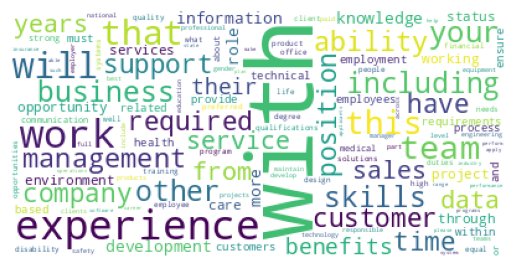

In [119]:
fig, ax = plt.subplots()
ax.imshow(wc)
ax.axis("off")

In [147]:
img = cv2.imread("colombia.jpg", cv2.IMREAD_GRAYSCALE)

(-0.5, 489.5, 611.5, -0.5)

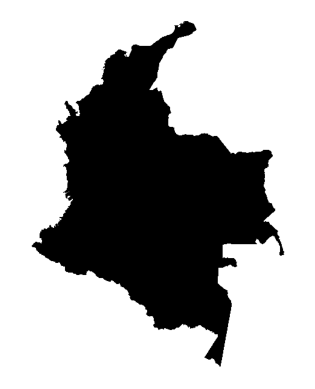

In [155]:
fig, ax = plt.subplots()
img2 = (img > 200).astype(np.uint8) * 255
ax.imshow(img2, cmap="gray")
ax.axis("off")

In [158]:
wc = WordCloud(
    background_color="white",
    mask = img2,
    width=700, height=700,
    ).generate_from_frequencies(freqs)

(-0.5, 489.5, 611.5, -0.5)

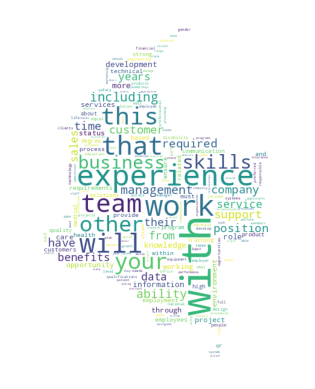

In [159]:
fig, ax = plt.subplots()
ax.imshow(wc)
ax.axis("off")

- $\text{TFIDF}$: Term Frequency - Inverse Document Frequency
- $\text{TF}$: Term frequency - bow.
- $t_j$: termino del vocabulario.
- $d_i$: documento del corpus.
- $N$: numero de documentos en el corpus.


$$
\text{TFIDF}(d_i, t_j) = \text{TF}(d_i, t_j) \cdot w_{IDF}(t_j)\\
w_{IDF}(t_j) = 1 + \log{\frac{N}{1 + \text{DF}(t_j)}}
$$

In [163]:
vect = TfidfVectorizer(
    use_idf=False, norm=None, min_df=10
).fit(df.corpus)

In [164]:
tfidf = vect.transform(df.corpus)

In [167]:
tfidf[:100, :100].toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 2.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [178]:
vect = TfidfVectorizer(
    min_df=10, sublinear_tf=True
).fit(df.corpus)

In [179]:
tfidf = vect.transform(df.corpus)

In [180]:
tfidf[:100, :100].toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.11231606],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [181]:
counts = np.array(tfidf.sum(axis=0)).flatten()
freqs = dict(zip(vect.get_feature_names_out(), counts))
freqs

{'aa': 9.408578465832758,
 'aama': 1.830774444757853,
 'aanapsi': 1.1581603342840818,
 'aap': 2.121481549538647,
 'aaprtl': 1.0188869026730076,
 'aba': 1.4240150261299047,
 'abap': 2.99019680657802,
 'abenity': 6.115961406395256,
 'abet': 3.129636142028241,
 'abide': 8.936928040774415,
 'abides': 1.7920553877942427,
 'abilities': 80.96823986139843,
 'ability': 325.2421677886158,
 'abilityability': 1.9026566802202267,
 'able': 183.54853370026345,
 'abnormal': 4.4826573383067565,
 'abnormalities': 1.1004287478102253,
 'aboriginal': 1.9735885528938013,
 'abound': 1.6102767796932593,
 'about': 224.9791837093181,
 'above': 72.27842733227837,
 'abreast': 13.841279472827017,
 'abroad': 2.3399430429005386,
 'absence': 27.33894440106506,
 'absences': 1.8556012675794982,
 'absent': 3.8966581843045422,
 'absolute': 3.931626115545932,
 'absolutely': 3.4680283940148557,
 'absorb': 1.2178172450479487,
 'absorbers': 0.8575419549804771,
 'abstract': 2.823504365935389,
 'abstracts': 1.1358012539020075,

(-0.5, 399.5, 199.5, -0.5)

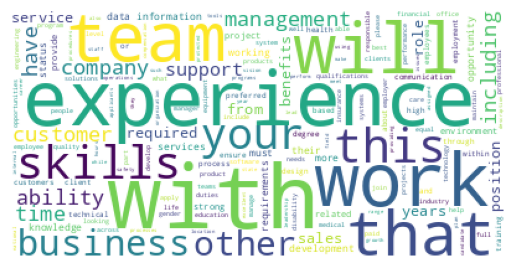

In [182]:
wc = WordCloud(background_color="white").generate_from_frequencies(freqs)
fig, ax = plt.subplots()
ax.imshow(wc)
ax.axis("off")